## SENG 474 Data Mining Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('google-play-store-apps/googleplaystore.csv')
#wait like 30s for this to finish
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


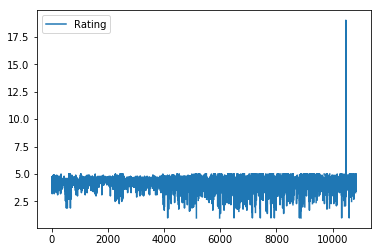

In [2]:
data.shape
data.plot(y=2)

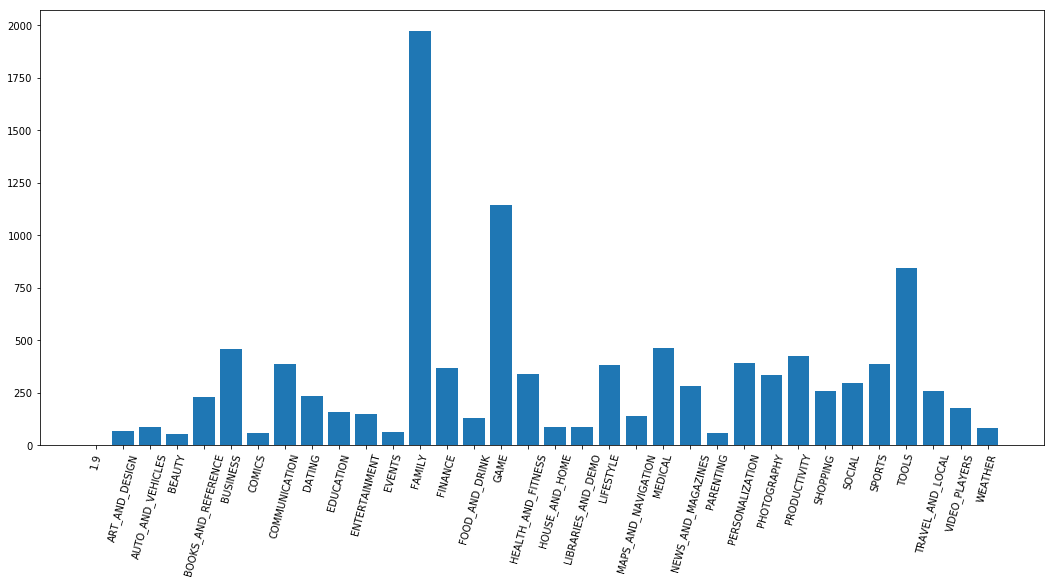

In [3]:
def count_unique(col):
    unique, counts = np.unique(col, return_counts=True)
    return np.array(list(zip(unique, counts)), dtype=object)

X = data.values

def plot_bar(col):
    categories = count_unique(col)

    fig, ax = plt.subplots(figsize=(18,8))
    y_pos = np.arange(len(categories[:, 0]))
    plt.bar(y_pos, categories[:, 1])
    plt.xticks(y_pos, categories[:, 0])
    plt.xticks(rotation=75)
    
plot_bar(X[:, 1])
#categories

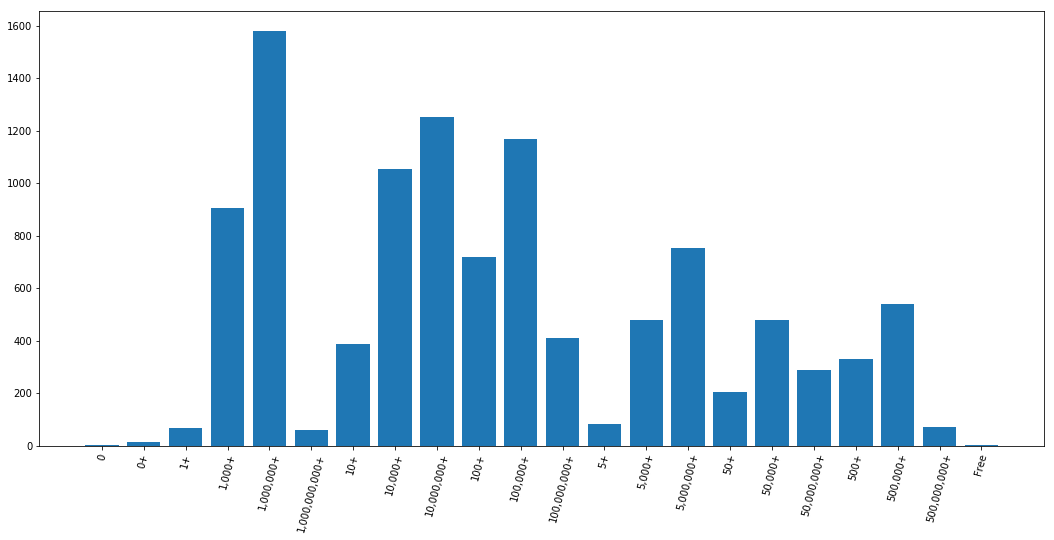

In [5]:
plot_bar(X[:, 5])
#installs, needs to be sorted

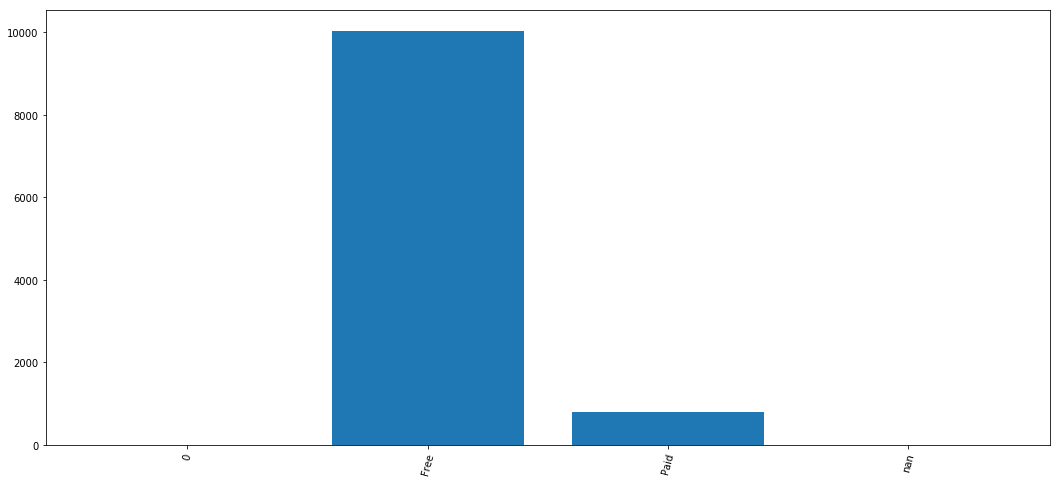

In [13]:
plot_bar(X[:, 6].astype(np.str))
#paid, need to clean bad values, pie chart

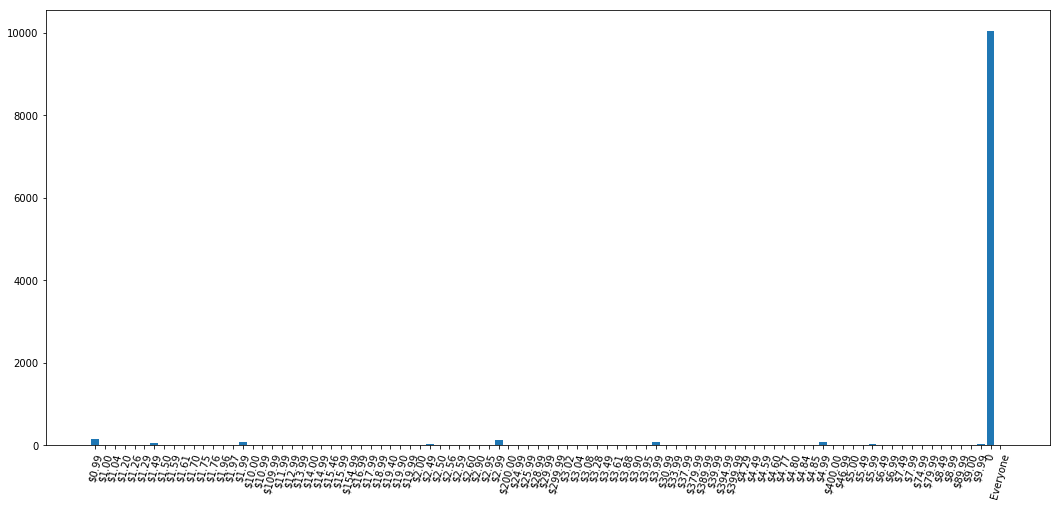

In [14]:
plot_bar(X[:, 7])
#price, probably bell curve

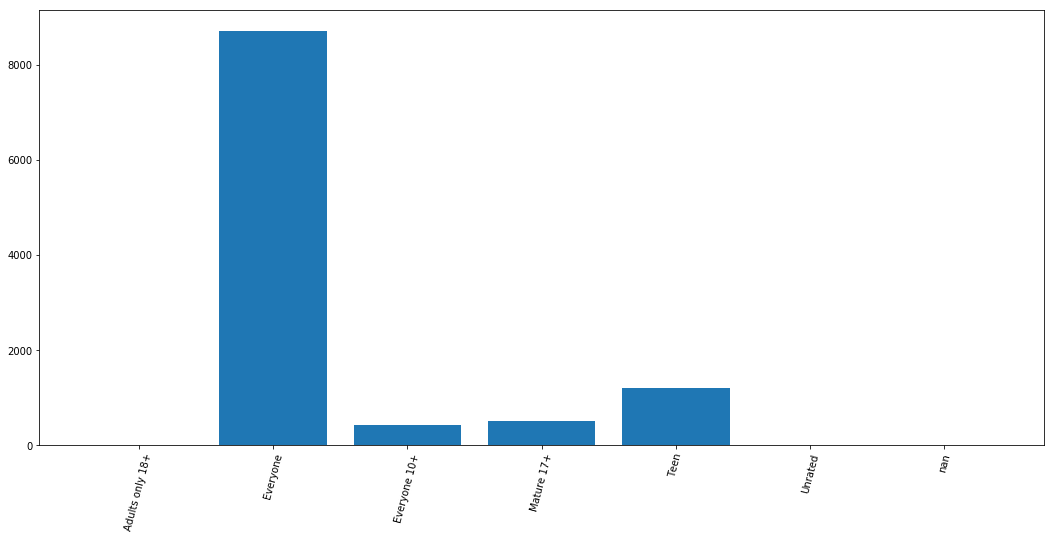

In [16]:
plot_bar(X[:, 8].astype(np.str))
#rating, need to clean dead values

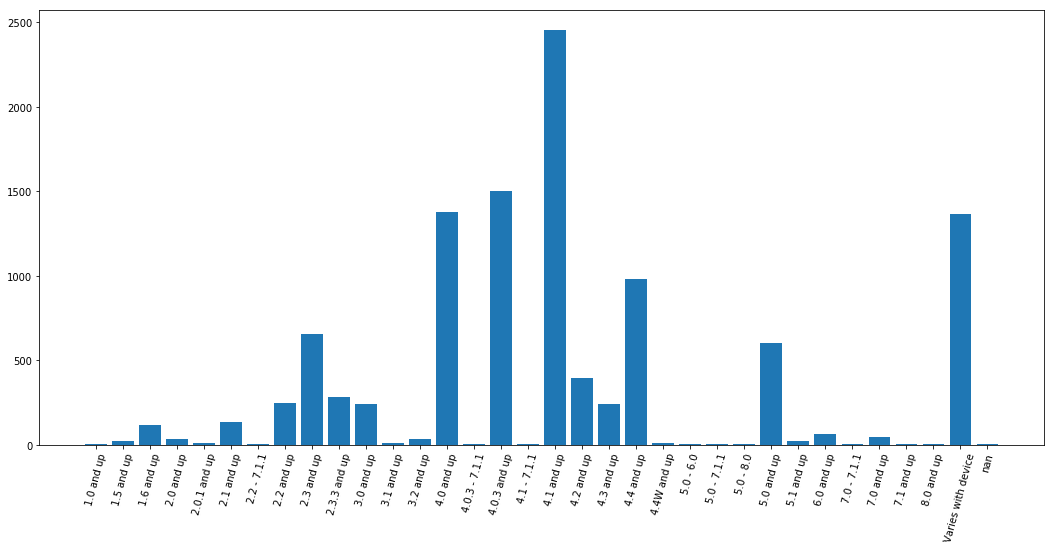

In [19]:
plot_bar(X[:, 12].astype(np.str))
#versions, data unclear because of ranges.